# Creating a new mechanism

In [1]:
import numpy as np
import pandas as pd
import pymarket as pm
import matplotlib.pyplot as plt
from pprint import pprint

One of the advantages of `PyMarket` is the ability to easily implement and test a new idea for a mechanism. Here we will show how to implement a new mechanism and use it.

## The uniform price mechanism

We are going to implement a uniform price mechanism that charges every trading player the clearing price.

As a reference we are going to be implement the example [Here](http://pierrepinson.com/31761/Lectures/31761-Lecture1.pdf)

We can begin by adding the corresponding bids to a new market

In [2]:
mar = pm.Market()

buyers_names = ['CleanRetail', 'El4You', 'EVcharge', 'QualiWatt', 'IntelliWatt']

mar.accept_bid(250, 200, 0, True) # CleanRetail  0
mar.accept_bid(300, 110, 1, True) # El4You       1
mar.accept_bid(120, 100, 2, True) # EVcharge     2
mar.accept_bid( 80,  90, 3, True) # QualiWatt    3
mar.accept_bid( 40,  85, 4, True) # IntelliWatt  4
mar.accept_bid( 70,  75, 1, True) # El4You       5
mar.accept_bid( 60,  65, 0, True) # CleanRetail  6
mar.accept_bid( 45,  40, 4, True) # IntelliWatt  7
mar.accept_bid( 30,  38, 3, True) # QualiWatt    8
mar.accept_bid( 35,  31, 4, True) # IntelliWatt  9
mar.accept_bid( 25,  24, 0, True) # CleanRetail  10
mar.accept_bid( 10,  21, 1, True) # El4You       11

sellers_names = ['RT', 'WeTrustInWind', 'BlueHydro', 'KøbenhavnCHP', 'DirtyPower', 'SafePeak']

mar.accept_bid(120,   0, 5, False) # RT             12
mar.accept_bid(50,    0, 6, False) # WeTrustInWind  13
mar.accept_bid(200,  15, 7, False) # BlueHydro      14
mar.accept_bid(400,  30, 5, False) # RT             15
mar.accept_bid(60, 32.5, 8, False) # KøbenhavnCHP   16
mar.accept_bid(50,   34, 8, False) # KøbenhavnCHP   17
mar.accept_bid(60,   36, 8, False) # KøbenhavnCHP   18
mar.accept_bid(100,37.5, 9, False) # DirtyPower     19
mar.accept_bid(70,   39, 9, False) # DirtyPower     20
mar.accept_bid(50,   40, 9, False) # DirtyPower     21
mar.accept_bid(70,   60, 5, False) # RT             22
mar.accept_bid(45,   70, 5, False) # RT             23
mar.accept_bid(50,  100, 10, False) # SafePeak      24
mar.accept_bid(60,  150, 10, False) # SafePeak      25
mar.accept_bid(50,  200, 10, False) # SafePeak      26

26

In [3]:
12, 15, 22, 23

(12, 15, 22, 23)

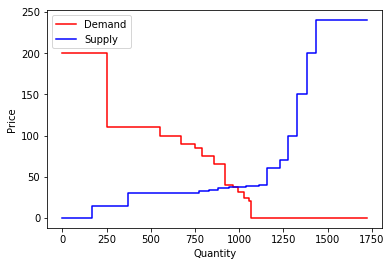

In [4]:
mar.plot()

## Implementing the mechanism

All market mechanisms take as arguements a bids dataframe (as well as possibly extra parameters) and returns a `TransactionManager` and an `extras`  dictionary.

In [13]:
def uniform_price_mechanism(bids: pd.DataFrame) -> (pm.TransactionManager, dict):
    
    trans = pm.TransactionManager()
    
    buy, _ = pm.bids.demand_curve_from_bids(bids) # Creates demand curve from bids
    sell, _ = pm.bids.supply_curve_from_bids(bids) # Creates supply curve from bids

    # q_ is the quantity at which supply and demand meet
    # price is the price at which that happens
    # b_ is the index of the buyer in that position
    # s_ is the index of the seller in that position
    q_, b_, s_, price = pm.bids.intersect_stepwise(buy, sell)
    
    buying_bids  = bids.loc[bids['buying']].sort_values('price', ascending=False)
    selling_bids = bids.loc[~bids['buying']].sort_values('price', ascending=True)
    
    ## Filter only the trading bids.
    buying_bids = buying_bids.iloc[: b_ + 1, :]
    selling_bids = selling_bids.iloc[: s_ + 1, :]
    
    # Find the long side of the market
    buying_quantity = buying_bids.quantity.sum()
    selling_quantity = selling_bids.quantity.sum()
    
    
    if buying_quantity > selling_quantity:
        long_side = buying_bids
        short_side = selling_bids
    else:
        long_side = selling_bids
        short_side = buying_bids
        
    traded_quantity = short_side.quantity.sum()
    
    ## All the short side will trade at `price`
    ## The -1 is there because there is no clear 1 to 1 trade.
    for i, x in short_side.iterrows():
        t = (i, x.quantity, price, -1, False)
        trans.add_transaction(*t)

    ## The long side has to trade only up to the short side
    quantity_added = 0
    for i, x in long_side.iterrows():
        
        if x.quantity + quantity_added <= traded_quantity:
            x_quantity = x.quantity
        else:
            x_quantity = traded_quantity - quantity_added
        t = (i, x_quantity, price, -1, False)
        trans.add_transaction(*t)
        quantity_added += x.quantity
        
    extra = {
        'clearing quantity': q_,
        'clearing price': price
    }
    
    
    
    return trans, extra

## Wrapping the algorithm as a mechanism

In [14]:
# Observe that we add as the second argument of init the algorithm just coded
class UniformPrice(pm.Mechanism):
    """
    Interface for our new uniform price mechanism.
    
    Parameters
    -----------
    bids
        Collection of bids to run the mechanism
        with.
    """

    def __init__(self, bids, *args, **kwargs):
        """TODO: to be defined1. """
        pm.Mechanism.__init__(self, uniform_price_mechanism, bids, *args, **kwargs)

## Adding the new mechanism to the list of available mechanism of the market

In [15]:
pm.market.MECHANISM['uniform'] = UniformPrice

## Running the new mechanism and comparing it with Huang's and P2P

In [24]:
stats = {}
for mec in ['uniform', 'huang', 'p2p']:
    t, e = mar.run(mec)
    stat = mar.statistics()
    stats[mec] = stat

### Profits for the players in the different mechanism

In [33]:
profits = pd.DataFrame([v['profits']['player_bid'] for k, v in stats.items()]).T
profits.columns = stats.keys()
profits

,uniform,huang,p2p
0,42275.0,41529.375,22890.0
1,24375.0,23849.375,12980.0
2,7500.0,7246.250,3150.0
3,4215.0,3997.500,2630.0
4,2012.5,1816.875,1162.5
5,7500.0,7500.000,14647.5
6,1875.0,1875.000,810.0
7,4500.0,4500.000,18500.0
8,565.0,565.000,3910.0
9,0.0,0.000,4570.0


### Percentage traded by mechanism

In [36]:
traded = pd.DataFrame([v['percentage_traded'].round(3) for k, v in stats.items()]).T
traded.columns = stats.keys()
traded

,uniform,huang,p2p
0,0.934,0.883,0.995


### Percentage of the maximum social welfare achieved by mechanism

In [38]:
welfare = pd.DataFrame([v['percentage_welfare'].round(3) for k, v in stats.items()]).T
welfare.columns = stats.keys()
welfare

,uniform,huang,p2p
0,1.0,0.98,0.903
